# Previsão de consumo de combustível

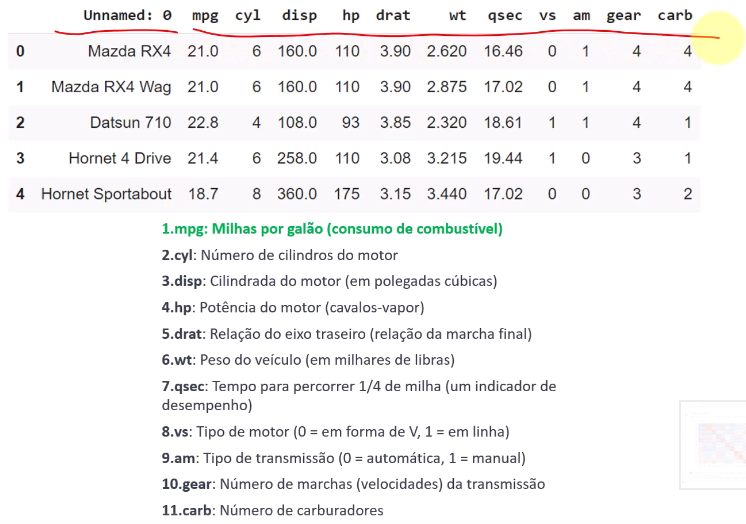

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import scipy.stats as stats
import seaborn as sns

In [2]:
from pathlib import Path
__THIS_PATH__ = Path().resolve()
__ROOT_PATH__ = __THIS_PATH__.parents[1]
__DATA_PATH__ = __ROOT_PATH__ / "data"

Visualizando o dataset

In [3]:
base_raw = pd.read_csv(__DATA_PATH__/ 'mt_cars.csv')
print(base_raw.shape)
base_raw.head()

(32, 12)


,Unnamed: 0,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [4]:
# Removendo a coluna de nomes - Variável que não interessa na REgresssao.
base = base_raw.drop(['Unnamed: 0'], axis=1)
base.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


Gerar uma matriz de correlação e gerar um heatmap com seaborn

<Axes: >

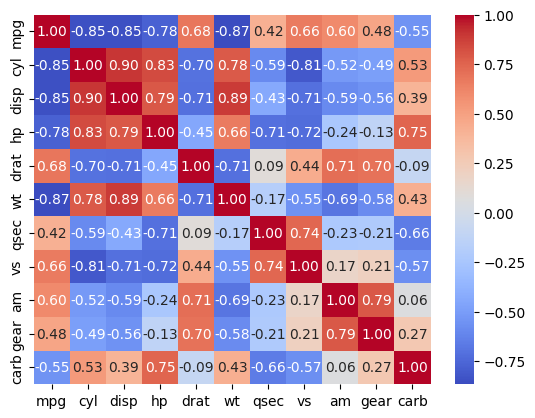

In [5]:
corr = base.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f')

In [6]:
corrs_filterd = corr.query('(mpg > .6 or mpg < -.6) and mpg != 1')['mpg'].sort_values(ascending=False).to_frame()

index = corrs_filterd.index
values = corrs_filterd.values

column_pairs = list(zip(['mpg'] * len(index),  index))
column_pairs

[('mpg', 'drat'),
 ('mpg', 'vs'),
 ('mpg', 'hp'),
 ('mpg', 'disp'),
 ('mpg', 'cyl'),
 ('mpg', 'wt')]

Outra forma de analisar essas variáveis é criando gráficos de dispersão.

Neste caso, estou selecionando alguns pares de colunas para análise de dispersão. Estou usando como critério o mpg (OBJETIVO) com as variáveis que tem correlação forte e moderada.

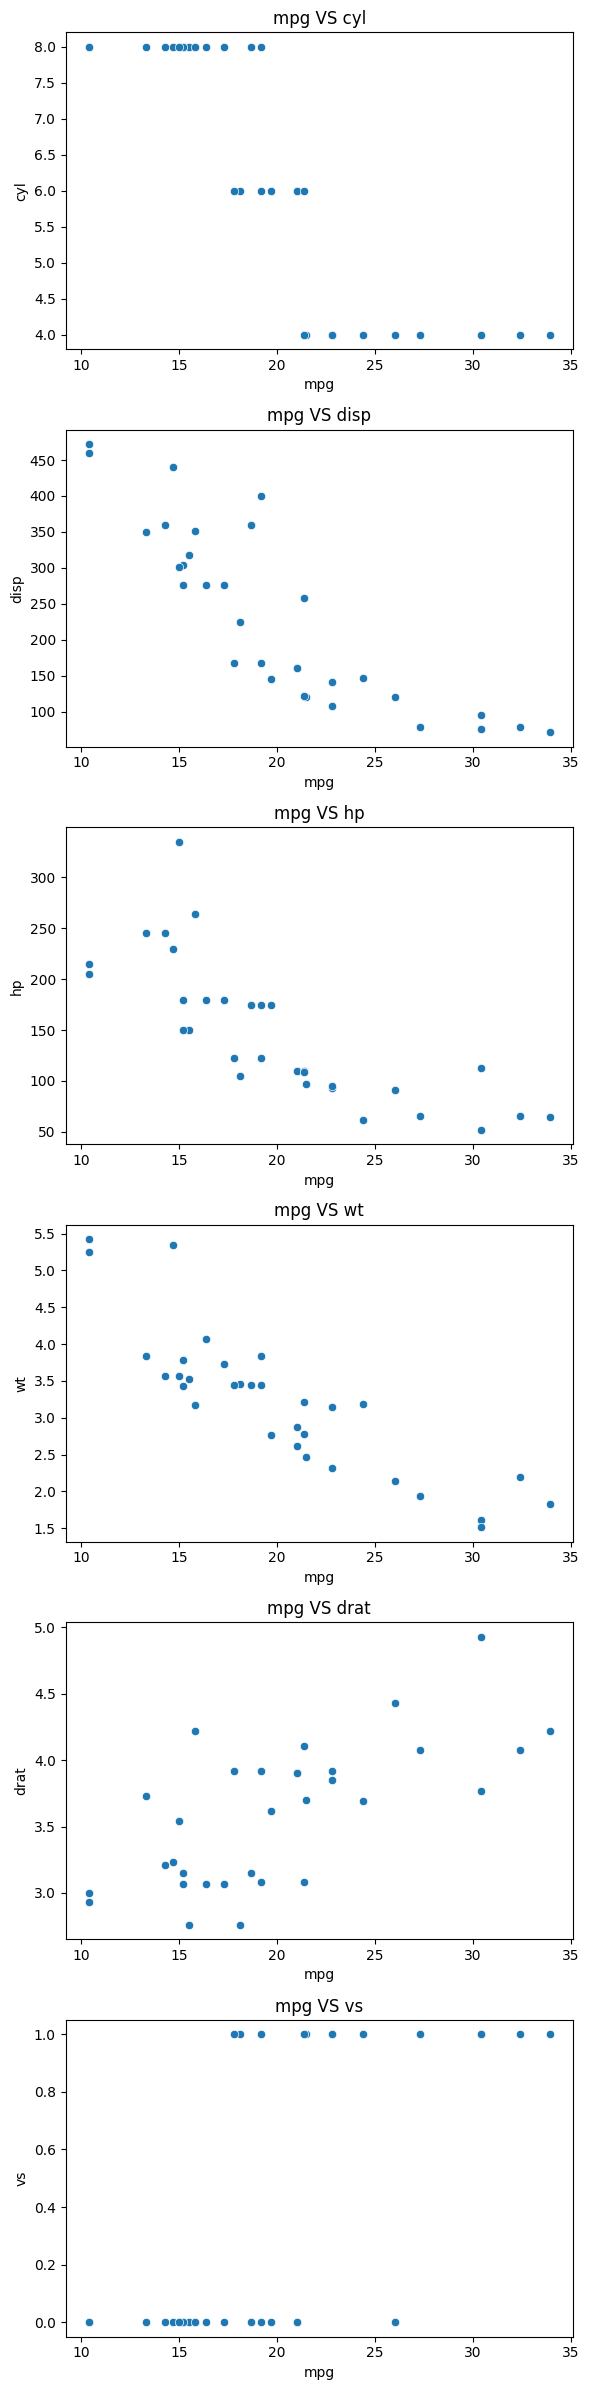

In [7]:
column_pairs = [('mpg','cyl'),('mpg','disp'),('mpg','hp'),('mpg','wt'),('mpg','drat'),('mpg','vs')]
numero_pares_plots = len(column_pairs)
fig, axes = plt.subplots(nrows=numero_pares_plots, ncols=1, figsize=(6,4 * numero_pares_plots))

for i, pair in enumerate(column_pairs):
  x_col, y_col = pair
  sns.scatterplot(x=x_col, y=y_col, data=base, ax=axes[i])
  axes[i].set_title(f'{x_col} VS {y_col}')

plt.tight_layout()
plt.show()

Os candidatos são:

- mpg VS cyl -> Não parece o numero de cilindros um bom candidato
- mpg VS disp -> bom candidato
- mpg VS hp -> bom candidato
- mpg VS wt -> bom candidato
- mpg VS drat -> bem disperso, não parece ser um bom candidato
- mpg VS vs -> ruim

Vamos agora avaliar as candidatas em termos de residuais. Poderia ser feito em relação a performance mas não é o objetivo do momento.

No StatsModel, passamos a formula onde a esquerda entra a variavel dependente, seguida do `~` e as variáveis dependentes a seguir.

In [8]:
def verifica_formula(formula):
    modelo = sm.ols(formula=formula, data=base).fit()
    print(modelo.summary())

    # Residuais visto em histograma - Busca de algo parecido com Sino
    residuos = modelo.resid
    plt.hist(residuos, bins=20)
    plt.xlabel("Residuos")
    plt.ylabel("Frequencia")
    plt.title("Histograma de Residuos")
    plt.show()

    # Residuais visto em Q-Q Plot
    stats.probplot(residuos, dist="norm", plot=plt)
    plt.title("Q-Q Plot de Residuos")
    plt.show()

    # Shapiro-Wilk
    # h0 - dados estão normalmente distribuídos
    # p <= 0.05 rejeito a hipótese nula, (não estão normalmente distribuídos)
    # p > 0.05 não é possível rejeitar a h0
    stat, pval = stats.shapiro(residuos)
    print(f'Shapiro-Wilk statística: {stat:.3f}, p-value: {pval:.3f}')    



                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     44.57
Date:                Fri, 28 Feb 2025   Prob (F-statistic):           8.65e-11
Time:                        05:41:56   Log-Likelihood:                -74.321
No. Observations:                  32   AIC:                             156.6
Df Residuals:                      28   BIC:                             162.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.1055      2.111     17.579      0.0

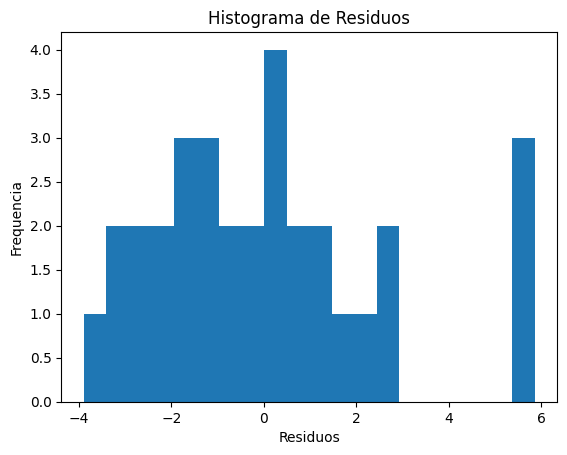

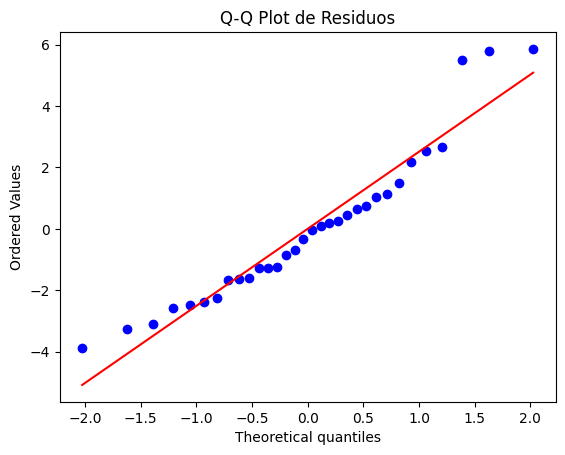

Shapiro-Wilk statística: 0.927, p-value: 0.033


In [9]:
#aic 156.6 bic 162.5
verifica_formula("mpg ~ wt + disp + hp")


                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     45.81
Date:                Fri, 28 Feb 2025   Prob (F-statistic):           1.06e-09
Time:                        05:41:56   Log-Likelihood:                -79.573
No. Observations:                  32   AIC:                             165.1
Df Residuals:                      29   BIC:                             169.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.6610      2.547     13.609      0.0

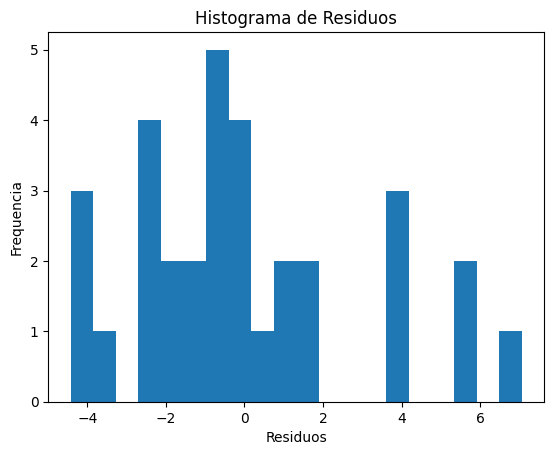

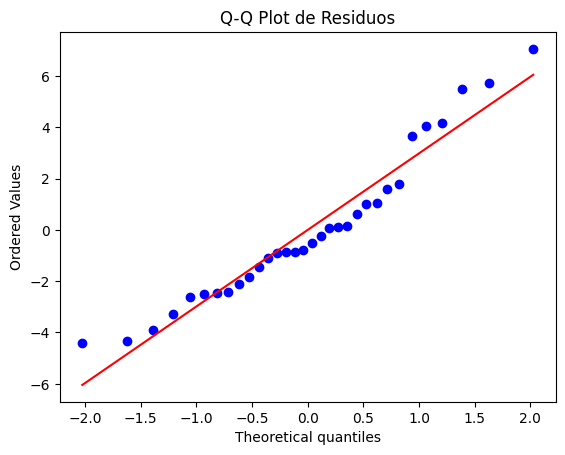

Shapiro-Wilk statística: 0.942, p-value: 0.085


In [10]:
#aic 165.1  bic 169.5
verifica_formula('mpg ~ disp + cyl')

Foi escolhido variáveis que tinham correlação moderada negativa.

- Mas há indicios que a performance AIC, BIC são piores
- O Histograma tem uma distribuição que parece um sino
- o Q-Q Plot parece estar melhor ajustado
- o P-value deu 0.822 muito proximo a 1

Fortes indícios de que os dados estão normalmente distribuídos.

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     24.53
Date:                Fri, 28 Feb 2025   Prob (F-statistic):           5.82e-07
Time:                        05:41:57   Log-Likelihood:                -86.536
No. Observations:                  32   AIC:                             179.1
Df Residuals:                      29   BIC:                             183.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8253      4.903     -0.372      0.7

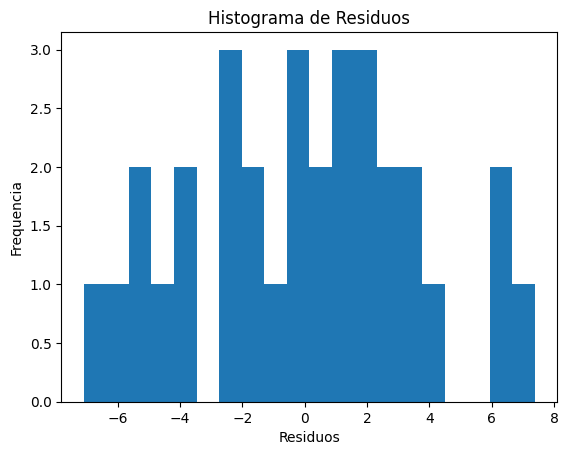

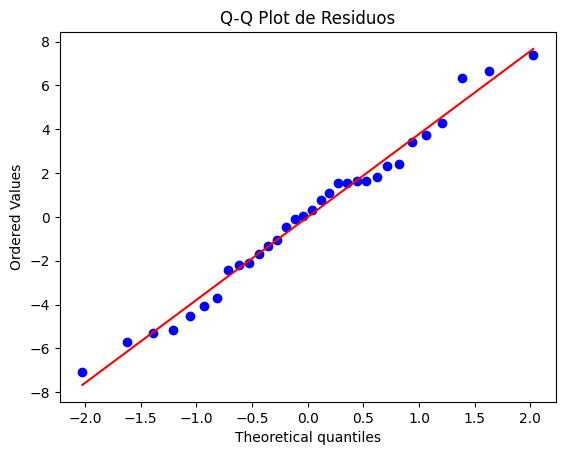

Shapiro-Wilk statística: 0.981, p-value: 0.822


In [11]:
#aic 179.1  bic 183.5
verifica_formula('mpg ~ drat + vs')

O instrutor teria escolhido o segundo modelo.